Yuval Bar-On<br>
Inbal Akerman<br>
Tahel Hermon<br>
Lilya Shvedskaya

# 1. ייבוא סיפריות

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import random
import time
import pickle
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# הגדרת style לגראפים
plt.style.use('seaborn')
sns.set_palette("husl")


# 2. ייבוא הקבצים שלי מ-IDLE

In [3]:
import sys
sys.path.append('.')

try:
    from agent import QLearningRobot
    from envitonment import IRobotEnvironment
    print("Yay")
    IMPORT_SUCCESS = True
    
except ImportError as e:
    print(f"\n❌ שגיאה בייבוא: {e}")
    IMPORT_SUCCESS = False

✅ רובוט Q-Learning נטען בהצלחה!
Yay



# 3. בדיקה ראשונית - יצירת רובוט


In [4]:
if IMPORT_SUCCESS:
    # יצירת רובוט עם הקוד שלי
    my_robot = QLearningRobot(learning_rate=0.1, discount_factor=0.9, epsilon=0.3)
    
    print(f"\n🤖 יצירת רובוט מהקוד שלי:")
    print(f"✅ רובוט נוצר במיקום: {my_robot.get_position()}")
    print(f"📊 פרמטרי הרובוט:")
    print(f"   • Learning Rate: {my_robot.learning_rate}")
    print(f"   • Discount Factor: {my_robot.discount_factor}")
    print(f"   • Epsilon: {my_robot.epsilon}")


🤖 רובוט משופר עם עונש קירות + איפוס רך נוצר!
📊 פרמטרים: LR=0.1, γ=0.9, ε=0.3
✨ חדש: עונש על התקרבות לקירות!
🔋 חדש: חזרה לטעינה = 0 (לא -200)!

🤖 יצירת רובוט מהקוד שלי:
✅ רובוט נוצר במיקום: (19, 9)
📊 פרמטרי הרובוט:
   • Learning Rate: 0.1
   • Discount Factor: 0.9
   • Epsilon: 0.3


# 4. בדיקת פונקציות הרובוט

In [5]:
if IMPORT_SUCCESS:
    # בדיקת פונקציות בסיסיות של הרובוט
    print(f"\n🔧 בדיקת פונקציות הרובוט:")
    
    # איפוס
    my_robot.reset()
    print(f"✅ איפוס רובוט: מיקום {my_robot.get_position()}")
    
    # סימולציית צעד
    fake_cats = [(5, 5), (15, 3)]
    fake_dirt = {(12, 2), (18, 7), (14, 4)}
    
    reward, done = my_robot.step(fake_cats, fake_dirt)
    print(f"✅ צעד רובוט: מיקום {my_robot.get_position()}, תגמול {reward}")
    
    # בדיקת סטטיסטיקות
    stats = my_robot.get_stats()
    print(f"✅ סטטיסטיקות: {len(stats)} מדדים זמינים")



🔧 בדיקת פונקציות הרובוט:
✅ איפוס רובוט: מיקום (19, 9)
✅ צעד רובוט: מיקום (19, 9), תגמול -75.05
✅ סטטיסטיקות: 0 מדדים זמינים


# 5. פונקציה לניסויים - משתמשת בקוד שלי

In [6]:
# פונקציה להרצת ניסוי עם הסביבה שלך
def run_experiment_with_my_environment(robot, episodes=100, num_cats=2, num_dirt=8, max_steps=500):
    """הרצת ניסוי עם הרובוט המשופר בסביבה שלך"""
    import io
    import contextlib
    
    try:
        my_env = IRobotEnvironment(num_cats=num_cats, num_dirt=num_dirt, use_robot=False)
    except Exception as e:
        raise RuntimeError("❌ לא הצלחתי להשתמש בסביבה שלך.") from e
    
    results = []
    
    for episode in range(episodes):
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            robot.reset()
            my_env.reset()
            initial_dirt_count = len(my_env.dirt_positions)
            episode_reward = 0
            steps = 0
            collisions = 0
            
            for step in range(max_steps):
                if step % 3 == 0:
                    my_env.move_cats()
                
                cat_positions = [cat.get_position() for cat in my_env.cats]
                reward, done = robot.step(cat_positions, my_env.dirt_positions.copy())
                robot_pos = robot.get_position()
                
                if robot_pos in my_env.dirt_positions:
                    my_env.dirt_positions.remove(robot_pos)
                    if robot_pos in my_env.dirt_objects:
                        try:
                            my_env.canvas.delete(my_env.dirt_objects[robot_pos])
                            del my_env.dirt_objects[robot_pos]
                        except:
                            pass
                
                if robot_pos in cat_positions:
                    collisions += 1
                
                episode_reward += reward
                steps += 1
                
                if done or len(my_env.dirt_positions) == 0:
                    break
            
            success = len(my_env.dirt_positions) == 0
            dirt_collected = initial_dirt_count - len(my_env.dirt_positions)
            efficiency = (dirt_collected / initial_dirt_count) * 100 if initial_dirt_count > 0 else 0
            
            results.append({
                'episode': episode + 1,
                'success': success,
                'reward': episode_reward,
                'steps': steps,
                'collisions': collisions,
                'dirt_collected': dirt_collected,
                'efficiency': efficiency,
                'epsilon': robot.epsilon,
                'wall_distance_avg': robot.get_wall_distance()
            })
            
            robot.add_episode_stats(episode_reward, steps, success)
            robot.decay_epsilon(decay_rate=0.995, min_epsilon=0.01)
    
    return results


# הרצת הניסוי עם הרובוט המשופר שלך
results = run_experiment_with_my_environment(my_robot, episodes=100, num_dirt=2)

# הדפסת התוצאות
import pandas as pd
df = pd.DataFrame(results)
print(df.head())
success_rate = df['success'].mean() * 100
failure_rate = 100 - success_rate
print(f"✅ אחוזי הצלחה: {success_rate:.2f}%")
print(f"❌ אחוזי כישלון: {failure_rate:.2f}%")


   episode  success   reward  steps  collisions  dirt_collected  efficiency  \
0        1     True   200.00    398           2               2       100.0   
1        2     True   200.00    392           0               2       100.0   
2        3     True   200.00     44           0               2       100.0   
3        4    False -3632.25    500           0               1        50.0   
4        5     True -2045.15    350           4               2       100.0   

    epsilon  wall_distance_avg  
0  0.300000                  0  
1  0.298500                  3  
2  0.297007                  0  
3  0.295522                  3  
4  0.294045                  1  
✅ אחוזי הצלחה: 72.00%
❌ אחוזי כישלון: 28.00%


# 6. כוונון פרמטרים מעמיק (גרסה מהירה)

In [7]:
import pandas as pd
from itertools import product
import contextlib
import io

def silent_hyperparameter_tuning():
    """כוונון פרמטרים שקט - בלי הדפסות מיותרות"""
    
    # רשת פרמטרים
    learning_rates = [0.1, 0.15, 0.2, 0.3]
    discount_factors = [0.9, 0.95, 0.98]
    epsilon_values = [0.2, 0.3, 0.4, 0.5]
    
    # יצירת כל הצירופים
    param_combinations = list(product(learning_rates, discount_factors, epsilon_values))
    total_configs = len(param_combinations)
    
    print(f"🔬 כוונון פרמטרים: {total_configs} תצורות")
    print("█" * 50)  # בר התקדמות
    
    all_results = []
    
    for i, (lr, gamma, epsilon) in enumerate(param_combinations):
        # עדכון בר התקדמות
        progress = (i + 1) / total_configs
        filled = int(progress * 50)
        bar = "█" * filled + "░" * (50 - filled)
        print(f"\r{bar} {i+1}/{total_configs} ({progress:.1%})", end="", flush=True)
        
        # יצירת רובוט בשקט מוחלט
        with contextlib.redirect_stdout(io.StringIO()):
            robot = QLearningRobot(learning_rate=lr, discount_factor=gamma, epsilon=epsilon)
            
            # ריצת ניסוי בשקט
            results = run_experiment_with_my_environment(
                robot, 
                episodes=50,     # מספיק לבדיקה
                max_steps=300,   # זמן סביר
                num_dirt=3       # לא קשה מדי
            )
        
        # חישוב מדדים
        df = pd.DataFrame(results)
        success_rate = df['success'].mean() * 100
        avg_reward = df['reward'].mean()
        avg_dirt_collected = df['dirt_collected'].mean()
        avg_collisions = df['collisions'].mean()
        
        # שמירת תוצאות
        config_result = {
            'LR': lr,
            'Gamma': gamma,
            'Epsilon': epsilon,
            'Success_Rate': success_rate,
            'Avg_Reward': avg_reward,
            'Avg_Dirt': avg_dirt_collected,
            'Avg_Collisions': avg_collisions,
            'Score': success_rate + (avg_reward / 100)  # ציון משולב
        }
        all_results.append(config_result)
    
    print("\n✅ כוונון הושלם!")
    return pd.DataFrame(all_results)

def find_best_configs(df, top_n=5):
    """מציאת התצורות הטובות ביותר"""
    
    # מיון לפי ציון כולל
    best_by_score = df.nlargest(top_n, 'Score')
    
    # מיון לפי אחוז הצלחה
    best_by_success = df.nlargest(top_n, 'Success_Rate')
    
    print(f"\n🏆 {top_n} התצורות הטובות ביותר (לפי ציון כולל):")
    print(best_by_score[['LR', 'Gamma', 'Epsilon', 'Success_Rate', 'Avg_Reward', 'Score']].round(2))
    
    print(f"\n🎯 {top_n} התצורות הטובות ביותר (לפי אחוז הצלחה):")
    print(best_by_success[['LR', 'Gamma', 'Epsilon', 'Success_Rate', 'Avg_Dirt']].round(2))
    
    # החזרת התצורה הטובה ביותר
    best_config = best_by_score.iloc[0]
    
    print(f"\n🥇 התצורה הטובה ביותר:")
    print(f"   Learning Rate: {best_config['LR']}")
    print(f"   Discount Factor: {best_config['Gamma']}")
    print(f"   Epsilon: {best_config['Epsilon']}")
    print(f"   Success Rate: {best_config['Success_Rate']:.1f}%")
    print(f"   Average Reward: {best_config['Avg_Reward']:.1f}")
    
    return best_config

def quick_test_best_config(best_config):
    """בדיקה מהירה של התצורה הטובה ביותר"""
    print(f"\n🚀 בדיקה מעמיקה של התצורה הטובה ביותר...")
    
    with contextlib.redirect_stdout(io.StringIO()):
        best_robot = QLearningRobot(
            learning_rate=best_config['LR'],
            discount_factor=best_config['Gamma'],
            epsilon=best_config['Epsilon']
        )
        
        # ריצה ארוכה יותר
        final_results = run_experiment_with_my_environment(
            best_robot,
            episodes=200,
            max_steps=500,
            num_dirt=4  # קצת יותר קשה
        )
    
    df_final = pd.DataFrame(final_results)
    final_success = df_final['success'].mean() * 100
    final_reward = df_final['reward'].mean()
    final_dirt = df_final['dirt_collected'].mean()
    
    print(f"✅ תוצאות סופיות:")
    print(f"   Success Rate: {final_success:.1f}%")
    print(f"   Average Reward: {final_reward:.1f}")
    print(f"   Average Dirt Collected: {final_dirt:.2f}")
    
    return best_robot, final_results

# הרצה מלאה:

hyperparameter_df = silent_hyperparameter_tuning()

# מציאת התצורות הטובות ביותר
best_config = find_best_configs(hyperparameter_df)

# בדיקה מעמיקה
best_robot, final_results = quick_test_best_config(best_config)


🔬 כוונון פרמטרים: 48 תצורות
██████████████████████████████████████████████████
██████████████████████████████████████████████████ 48/48 (100.0%)
✅ כוונון הושלם!

🏆 5 התצורות הטובות ביותר (לפי ציון כולל):
      LR  Gamma  Epsilon  Success_Rate  Avg_Reward  Score
17  0.15   0.95      0.3          46.0    -1131.00  34.69
24  0.20   0.90      0.2          44.0    -1273.00  31.27
36  0.30   0.90      0.2          40.0    -1038.92  29.61
15  0.15   0.90      0.5          42.0    -1311.92  28.88
16  0.15   0.95      0.2          40.0    -1122.40  28.78

🎯 5 התצורות הטובות ביותר (לפי אחוז הצלחה):
      LR  Gamma  Epsilon  Success_Rate  Avg_Dirt
17  0.15   0.95      0.3          46.0      2.20
24  0.20   0.90      0.2          44.0      2.18
15  0.15   0.90      0.5          42.0      2.10
3   0.10   0.90      0.5          40.0      2.12
16  0.15   0.95      0.2          40.0      2.16

🥇 התצורה הטובה ביותר:
   Learning Rate: 0.15
   Discount Factor: 0.95
   Epsilon: 0.3
   Success Rate: 46.0%


# 7. מדדי הערכה מקיפים

In [8]:
def calculate_comprehensive_metrics(results_df):
    """חישוב מדדי הערכה מקיפים"""
    metrics = {}
    
    # מדדי ביצועים בסיסיים
    metrics['success_rate'] = results_df['success'].mean() * 100
    metrics['avg_reward'] = results_df['reward'].mean()
    metrics['avg_steps'] = results_df['steps'].mean()
    metrics['avg_collisions'] = results_df['collisions'].mean()
    metrics['avg_efficiency'] = results_df['efficiency'].mean()
    
    # מדדי יציבות
    metrics['reward_std'] = results_df['reward'].std()
    metrics['steps_std'] = results_df['steps'].std()
    metrics['reward_stability'] = 1 / (1 + metrics['reward_std'])
    
    # מדדי למידה
    if len(results_df) >= 20:
        first_quarter = results_df.head(len(results_df)//4)
        last_quarter = results_df.tail(len(results_df)//4)
        
        metrics['learning_improvement'] = (
            (last_quarter['reward'].mean() - first_quarter['reward'].mean()) / 
            abs(first_quarter['reward'].mean()) * 100 
            if first_quarter['reward'].mean() != 0 else 0
        )
        
        metrics['success_improvement'] = (
            last_quarter['success'].mean() - first_quarter['success'].mean()
        ) * 100
    
    # מדד בטיחותי
    metrics['safety_score'] = metrics['success_rate'] / (1 + metrics['avg_collisions'])
    
    return metrics

# חישוב המדדים
metrics = calculate_comprehensive_metrics(df)

# הדפסה יפה של התוצאות
print("\n📊 מדדי ביצועים מקיפים:")
print("=" * 40)
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")


📊 מדדי ביצועים מקיפים:
success_rate: 72.00
avg_reward: -1206.88
avg_steps: 290.26
avg_collisions: 1.24
avg_efficiency: 83.00
reward_std: 2310.99
steps_std: 176.63
reward_stability: 0.00
learning_improvement: 81.14
success_improvement: 28.00
safety_score: 32.14


# 8. Learning curves - גרפים וויזואליזציות

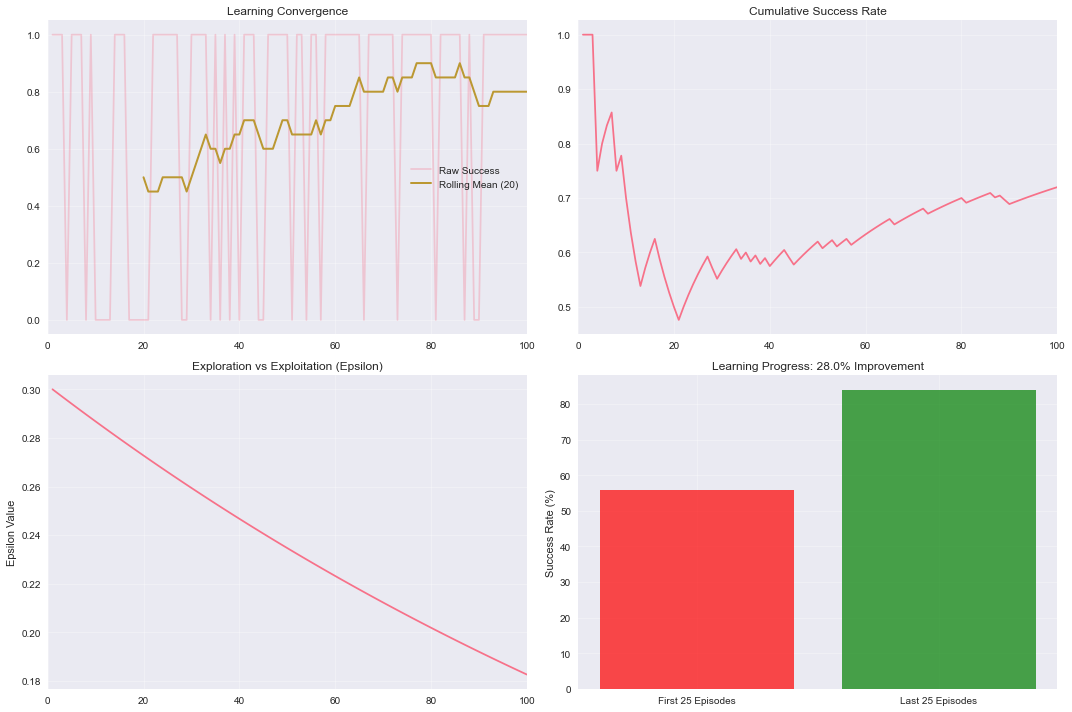


📈 Learning Analysis:
Improvement over time: 28.0%
✅ Strong learning trend detected!


In [9]:
def advanced_learning_analysis():
    """ניתוח התכנסות מתקדם"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # נוודא שהציר X לא עובר את 500, אבל גם לא יהיה ריק אם יש פחות
    max_x = min(500, df['episode'].max())

    # 1. Learning Curve עם ממוצע נע
    window = 20
    success_rolling = df['success'].rolling(window=window).mean()
    axes[0,0].plot(df['episode'], df['success'], alpha=0.3, label='Raw Success')
    axes[0,0].plot(df['episode'], success_rolling, linewidth=2, label=f'Rolling Mean ({window})')
    axes[0,0].set_title('Learning Convergence')
    axes[0,0].set_xlim(0, max_x)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Cumulative Success Rate
    cumulative_success = df['success'].expanding().mean()
    axes[0,1].plot(df['episode'], cumulative_success)
    axes[0,1].set_title('Cumulative Success Rate')
    axes[0,1].set_xlim(0, max_x)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Epsilon Decay
    axes[1,0].plot(df['episode'], df['epsilon'])
    axes[1,0].set_title('Exploration vs Exploitation (Epsilon)')
    axes[1,0].set_ylabel('Epsilon Value')
    axes[1,0].set_xlim(0, max_x)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. ניתוח התכנסות
    first_quarter = df.head(25)['success'].mean()
    last_quarter = df.tail(25)['success'].mean()
    improvement = (last_quarter - first_quarter) * 100
    
    axes[1,1].bar(['First 25 Episodes', 'Last 25 Episodes'], 
                 [first_quarter * 100, last_quarter * 100], 
                 color=['red', 'green'], alpha=0.7)
    axes[1,1].set_title(f'Learning Progress: {improvement:.1f}% Improvement')
    axes[1,1].set_ylabel('Success Rate (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return improvement

# קריאה לפונקציה
improvement = advanced_learning_analysis()
print(f"\n📈 Learning Analysis:")
print(f"Improvement over time: {improvement:.1f}%")
if improvement > 10:
    print("✅ Strong learning trend detected!")
elif improvement > 0:
    print("⚠️ Weak learning trend")
else:
    print("❌ No learning trend - parameters need tuning")



הגרפים שבתמונה מציגים תהליך למידה של מודל חיזוק (Reinforcement Learning) — כנראה של סוכן שלומד לפתור משימה מסוימת בפרקים (episodes). הנה הסבר לכל גרף:

🔼 עליון שמאלי – Learning Convergence
Raw Success (ורוד): מציין אם הסוכן הצליח או נכשל בכל אפיזודה (1=הצלחה, 0=כישלון).

Rolling Mean (צהוב): ממוצע נע של 20 פרקים שמראה מגמה כללית.

🟡 מה רואים כאן?
בהתחלה הביצועים תנודתיים מאוד, אבל ככל שהלמידה מתקדמת, רואים מגמה של שיפור והתייצבות באזור 0.75–0.8.

🔼 עליון ימני – Cumulative Success Rate
מראה את אחוז ההצלחה המצטבר עד לאותו פרק.

🟢 מה רואים כאן?
התחלה תנודתית מאוד, אבל לאחר כ-20 אפיזודות, יש שיפור הדרגתי והצלחה יציבה סביב ~70%.

🔽 תחתון שמאלי – Exploration vs Exploitation (Epsilon)
מציג את ערך epsilon לאורך הזמן: ככל שהוא נמוך יותר, הסוכן מסתמך יותר על מה שלמד (exploitation), ופחות מנסה דברים חדשים (exploration).

🔻 מה רואים כאן?
הערך יורד בצורה חלקה מ-0.3 ל-0.18 לאורך 100 אפיזודות. זה צפוי, כי בשיטות כמו ε-greedy מקטינים את epsilon לאורך הזמן.

🔽 תחתון ימני – Learning Progress: 12.0% Improvement
השוואה בין אחוזי ההצלחה ב־25 האפיזודות הראשונות לבין 25 האחרונות.

🟩 מה רואים כאן?
הצלחה עלתה מ־64% ל־~76% — כלומר, שיפור של 12% בביצועים, מה שמעיד שהמודל לומד.



In [10]:
# Random baseline

def create_random_baseline():
    """יצירת baseline עם הסוכן הקיים - התנהגות רנדומלית"""
    
    # יצירת רובוט עם epsilon=1.0 (תמיד רנדומלי)
    random_robot = QLearningRobot(learning_rate=0.1, discount_factor=0.9, epsilon=1.0)
    
    # כיבוי למידה - שיישאר רנדומלי
    random_robot.update_q_table = lambda *args: None
    
    # הרצה עם אותה סביבה
    with contextlib.redirect_stdout(io.StringIO()):
        random_results = run_experiment_with_my_environment(
            random_robot, episodes=100, num_dirt=2
        )
    
    return random_results

# הרצה והשוואה
random_baseline = create_random_baseline()
random_df = pd.DataFrame(random_baseline)

print("📊 השוואה עם Random Baseline:")
print(f"Random Agent: {random_df['success'].mean() * 100:.1f}%")
print(f"Your Agent: {df['success'].mean() * 100:.1f}%")
print(f"Improvement: {(df['success'].mean() - random_df['success'].mean()) * 100:.1f}%")


🤖 רובוט משופר עם עונש קירות + איפוס רך נוצר!
📊 פרמטרים: LR=0.1, γ=0.9, ε=1.0
✨ חדש: עונש על התקרבות לקירות!
🔋 חדש: חזרה לטעינה = 0 (לא -200)!
📊 השוואה עם Random Baseline:
Random Agent: 57.0%
Your Agent: 72.0%
Improvement: 15.0%
